In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
df = pd.read_csv(r'/content/Metro_Interstate_Traffic_Volume (1).csv')

In [3]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [5]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [6]:
holiday_le = preprocessing.LabelEncoder()
df['holiday_le'] = holiday_le.fit_transform(df['holiday'])
weather_main_le = preprocessing.LabelEncoder()
df['weather_main_le'] = weather_main_le.fit_transform(df['weather_main'])
weather_description_le = preprocessing.LabelEncoder()
df['weather_description_le'] = weather_description_le.fit_transform(df['weather_description'])

In [7]:
df = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']]

In [8]:
validate = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(10)
df.drop(df.tail(10).index,inplace=True)

In [9]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [10]:
validate = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(10)
df.drop(df.tail(10).index,inplace=True)

In [11]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']])
dataY = y_scaler.fit_transform(df[['traffic_volume']])

In [12]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [13]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.         0.92972555 0.         0.4        1.         0.1
  0.7        0.76167582]
 [0.         0.93320863 0.         0.75       1.         0.1
  0.06666667 0.62032967]
 [0.         0.93391815 0.         0.9        1.         0.1
  0.56666667 0.65480769]
 [0.         0.93569194 0.         0.9        1.         0.1
  0.56666667 0.69038462]
 [0.         0.93894927 0.         0.75       1.         0.1
  0.06666667 0.67554945]
 [0.         0.94081981 0.         0.01       1.         0.
  0.73333333 0.71167582]
 [0.         0.94549618 0.         0.01       1.         0.
  0.73333333 0.76703297]
 [0.         0.94772148 0.         0.01       1.         0.
  0.73333333 0.82623626]
 [0.         0.9486245  0.         0.2        1.         0.1
  0.13333333 0.79546703]
 [0.         0.94527042 0.         0.2        1.         0.1
  0.13333333 0.65521978]
 [0.         0.93840101 0.         0.2        1.         0.1
  0.13333333 0.48612637]
 [0.         0.93327313 0. 

In [14]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [15]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True),
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model_path = r'\Chapter 7\Bidirectional_LSTM_Multivariate.keras' # Change the file extension to .keras

In [17]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 0.1160 - val_loss: 0.0524
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0646 - val_loss: 0.0489
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0553 - val_loss: 0.0649
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0543 - val_loss: 0.0395
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0552 - val_loss: 0.0388
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0479 - val_loss: 0.0382
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0488 - val_loss: 0.0331
Epoch 8/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0447 - val_loss: 0.0350
Epoch 9/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0400 - val_loss: 0.0398
Epoch 10/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0379 - val_loss: 0.0583
Epoch 11/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0441 - val_loss: 0.0338
Epoch 12/150
100/100 ━━━━━━━━

In [18]:
Trained_model = tf.keras.models.load_model(model_path)

In [19]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 48, 300)             │         190,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100)                 │         140,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,292 (3.82 MB)

 Trainable params: 333,430 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 666,862 (2.54 MB)

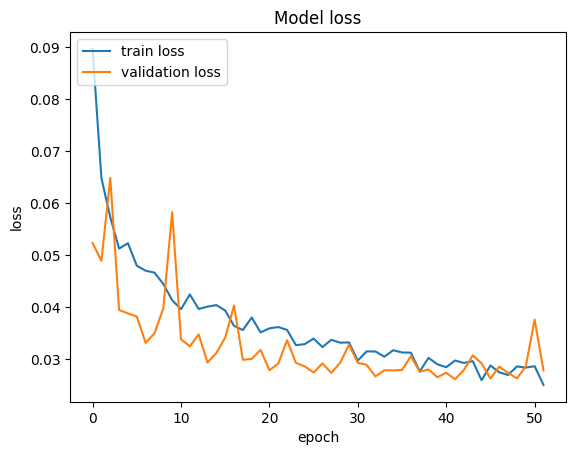

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [21]:
data_val = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(48))

In [22]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [23]:
Predicted_results = Trained_model.predict(val_rescaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


In [24]:
Predicted_results

array([[0.33015937, 0.31693348, 0.29144147, 0.26994663, 0.2687462 ,
        0.30927208, 0.37201238, 0.44469488, 0.51569736, 0.5795267 ]],
      dtype=float32)

In [25]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [26]:
Predicted_results_Inv_trans

array([[2403.5603, 2307.2756, 2121.6938, 1965.2115, 1956.4723, 2251.5007,
        2708.25  , 3237.3787, 3754.2769, 4218.9546]], dtype=float32)

In [27]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [28]:
timeseries_evaluation_metrics_func(validate['traffic_volume'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 1534690.799601081
MAE is : 1047.4574462890625
RMSE is : 1238.826379926211
MAPE is : 194.39741325461836
R2 is : 0.16116863489151



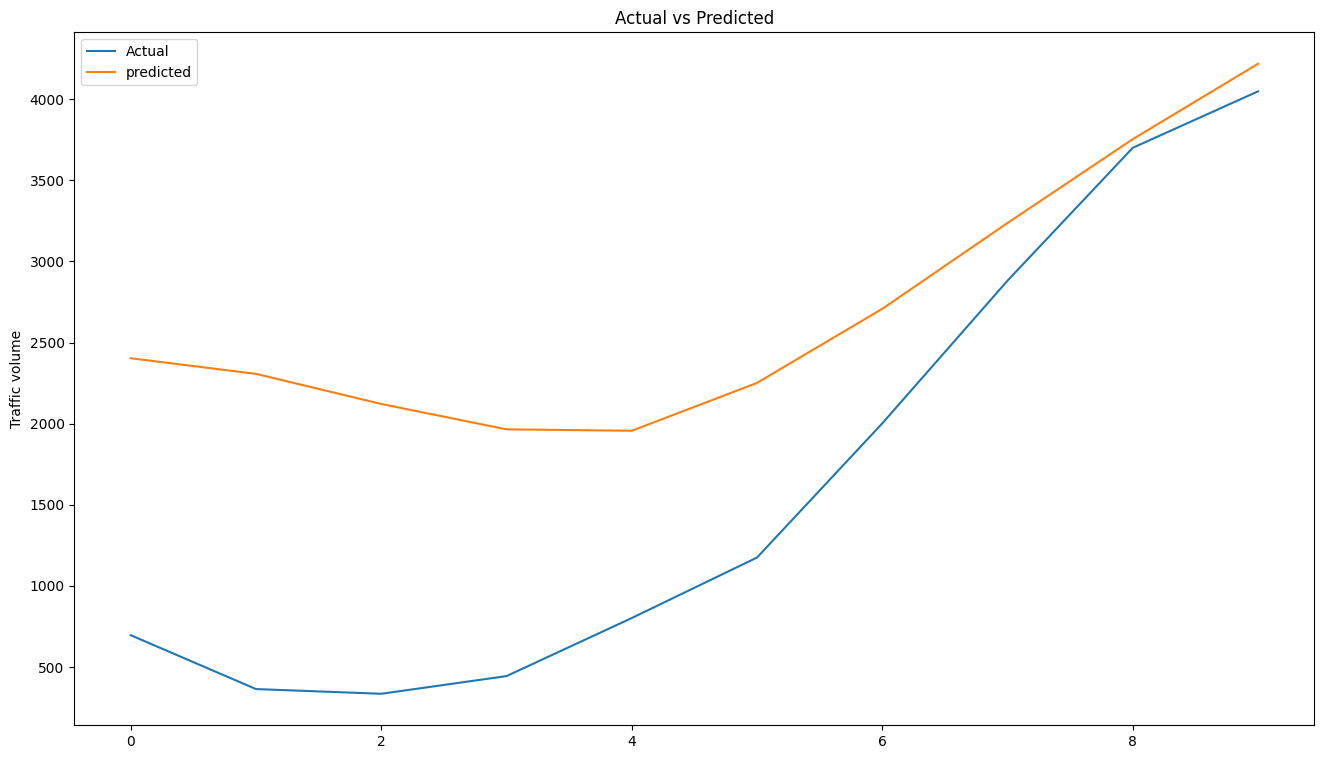

In [29]:
plt.plot( list(validate['traffic_volume']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()